<a href="https://colab.research.google.com/github/bw-spotify2/ds/blob/master/Song_Selector_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial building of the model.

### Load in the Dataset

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Lambda/Unit 4/Sprint 4/SpotifyFeatures.csv')
df.sample(10)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
114411,Rap,OneRepublic,Apologize,1NrJYpdAi7uosDRPmSYrsG,72,0.348000,0.591,208107,0.718,0.000118,G#,0.1070,-6.025,Major,0.0368,117.995,4/4,0.4680
50921,Blues,Clutch,Burning Beard,6VR2wTjJGtlBnQztwVCbQM,32,0.016900,0.246,240267,0.914,0.000302,G,0.2040,-5.751,Major,0.1700,172.658,3/4,0.5500
173572,Comedy,Todd Barry,Class Act,2MuNkC3q6wgiokxecNf3qN,17,0.773000,0.592,37253,0.441,0.000002,G,0.3850,-17.147,Major,0.9460,81.879,4/4,0.7130
34772,Anime,Capcom Sound Team,WINGS OF THE GUARDIAN(Lucia 戦闘1),5icjCWXAZ5My3lL0IRCo8w,15,0.000282,0.526,137133,0.938,0.899000,C#,0.0727,-5.773,Major,0.0618,140.003,4/4,0.7610
190831,Ska,Mad Caddies,Sad Reggie,6kWTjdU0Ul4qF4isRc5zU4,18,0.073300,0.556,291160,0.594,0.002620,D,0.1230,-6.982,Minor,0.0395,132.523,4/4,0.9310
92645,Hip-Hop,Three 6 Mafia,Hard Out Here for a Pimp,17ZCxegdCt1y0reBkHVmMB,47,0.022000,0.850,169187,0.705,0.000939,C,0.0721,-7.537,Major,0.0616,160.961,4/4,0.8390
182234,Movie,Idina Menzel,As Long As You're Mine,5qnYglSEqrPFXrrnyzIci2,38,0.754000,0.453,225987,0.446,0.000001,F,0.1050,-8.280,Major,0.0312,118.321,4/4,0.1770
164726,Reggaeton,Proyecto Uno,Call Me,5cLbbB9mhDaliYlgXA7Ztl,25,0.144000,0.819,238105,0.932,0.000009,A,0.0645,-6.529,Minor,0.0635,126.009,4/4,0.9590
86901,R&B,HONNE,Someone That Loves You (Late Night Version),6mbCABWxCDBrUNbiZa3pb0,50,0.904000,0.516,247546,0.179,0.001090,A#,0.1030,-10.777,Major,0.0400,128.582,5/4,0.0915
207350,World,Influence Music,Breathe - Live,5OfIpf1OOrbWYBBAMZpO5N,56,0.039200,0.328,360936,0.683,0.000001,E,0.1080,-6.913,Major,0.0424,143.675,4/4,0.1080


In [79]:
df['mode'] = df['mode'].replace({"Major":1, "Minor":0})
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,1,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,0,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,0,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,1,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,1,0.0456,140.576,4/4,0.390


In [80]:
df['time_signature'].value_counts()

4/4    200760
3/4     24111
5/4      5238
1/4      2608
0/4         8
Name: time_signature, dtype: int64

In [81]:
df['time_signature'] = df['time_signature'].replace({'4/4':4,'3/4':3,'5/4':5,'1/4':1,'0/4':0})
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,1,0.0525,166.969,4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,0,0.0868,174.003,4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,0,0.0362,99.488,5,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,1,0.0395,171.758,4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,1,0.0456,140.576,4,0.390


In [82]:
df['key'].value_counts()

C     27583
G     26390
D     24077
C#    23201
A     22671
F     20279
B     17661
E     17390
A#    15526
F#    15222
G#    15159
D#     7566
Name: key, dtype: int64

In [83]:
key_dict = {'C':0,'C#':1,'D':2,'D#':3,'E':4,'F':5,'F#':6,'G':7,'G#':8,'A':9,'A#':10,'B':11}
df['key'] = df['key'].replace(key_dict)
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,1,0.3460,-1.828,1,0.0525,166.969,4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,6,0.1510,-5.559,0,0.0868,174.003,4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,0,0.1030,-13.879,0,0.0362,99.488,5,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,1,0.0985,-12.178,1,0.0395,171.758,4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,5,0.2020,-21.150,1,0.0456,140.576,4,0.390


In [2]:
# Connect to the API in case we need to look at it's output

!pip install spotipy --upgrade
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time 

client_id = '14f59f665a094868921bdd76e420d7c0'
client_secret = '5e16ddb0f2ed45a69949330bbd34351a'
username = 'mahoryu'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Define the columns we want to use and make a df with it

In [3]:
# define headers
headers = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
df_new = df[headers]

In [4]:
df_new.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,0.0525,166.969,0.814
1,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,0.0868,174.003,0.816
2,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,0.0362,99.488,0.368
3,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,0.0395,171.758,0.227
4,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,0.0456,140.576,0.390


In [5]:
df_new.shape

(232725, 11)

### Make the model

In [6]:
# imports 

from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

Using TensorFlow backend.


In [7]:
# Normalise the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_new)

#### Pickle the Scaler

In [8]:
import pickle

# Dump the trained classifier (autoencoder)  with Pickle
pickle_filename_1 = 'scaler_model.pkl'
pickled_model_1 = open(pickle_filename_1, 'wb')  # Open the file to save as pkl file
pickle.dump(scaler, pickled_model_1)
pickled_model_1.close() # Close the pickle instances

# Loading the saved model
model_pkl_1 = open(pickle_filename_1, 'rb')
scaler_model = pickle.load(model_pkl_1)
print ("Loaded model :: ", scaler_model)  # print to verify

Loaded model ::  MinMaxScaler(copy=True, feature_range=(0, 1))


#### Create actual Model

In [9]:
# set the scaled data to a new df
df_scaled = pd.DataFrame(data_scaled,columns=headers)
df_scaled.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.00,0.613454,0.356292,0.015167,0.910909,0.000000,0.339614,0.900856,0.032070,0.642704,0.814
1,0.01,0.246988,0.571934,0.022029,0.737732,0.000000,0.142710,0.834469,0.068374,0.675801,0.816
2,0.03,0.955823,0.650252,0.027969,0.131113,0.000000,0.094241,0.686429,0.014818,0.325182,0.368
3,0.00,0.705823,0.196438,0.024747,0.326313,0.000000,0.089697,0.716695,0.018311,0.665238,0.227
4,0.04,0.953815,0.294067,0.012142,0.225209,0.123123,0.194208,0.557054,0.024767,0.518516,0.390


In [71]:
# create the actual autoencoder

# set the input dimentions to what is in the df_new
input_dim = df_new.shape[1]  # 11

# Number of neurons in each Layer [11, 7, 3, ...] of encoders
input_layer = Input(shape=(input_dim, ))
encoder_layer_1 = Dense(7, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder_layer_2 = Dense(3, activation="relu")(encoder_layer_1)

# Crear encoder model
encoder = Model(inputs=input_layer, outputs=encoder_layer_2)

decoder_1 = Dense(7, activation='relu')(encoder_layer_2)
decoder_output = Dense(input_dim, activation = 'sigmoid')(decoder_1)

autoencoder = Model(input_layer, decoder_output)

autoencoder.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 11)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 7)                 84        
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 24        
_________________________________________________________________
dense_69 (Dense)             (None, 7)                 28        
_________________________________________________________________
dense_70 (Dense)             (None, 11)                88        
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [72]:
# compile the autoencoder
autoencoder.compile(optimizer='nadam',
                    loss='binary_crossentropy') 
                    
# fit the model
autoencoder.fit(df_scaled, df_scaled,
                epochs=10,
                batch_size=128,
                validation_split=0.2) 

Train on 186180 samples, validate on 46545 samples
Epoch 1/10
186180/186180 [==============================] - 5s 27us/step - loss: 0.5155 - val_loss: 0.4930
Epoch 2/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4964 - val_loss: 0.4813
Epoch 3/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4818 - val_loss: 0.4674
Epoch 4/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4710 - val_loss: 0.4643
Epoch 5/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4685 - val_loss: 0.4633
Epoch 6/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4677 - val_loss: 0.4618
Epoch 7/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4671 - val_loss: 0.4615
Epoch 8/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4666 - val_loss: 0.4616
Epoch 9/10
186180/186180 [==============================] - 5s 26us/step - loss: 0.4662 - val

In [ ]:
########
## try resonstructing a song to see accuracy visually.
########

In [30]:
# Use the model to predict the factors which sum up the selected atributes of the songs,
#   by making an encoded_data df.
encoded_data = pd.DataFrame(encoder.predict(data_scaled))
encoded_data.columns = ['x', 'y']
encoded_data.head()

,x,y
0,1.544497,0.828815
1,1.729073,0.819911
2,1.464176,1.673386
3,1.079835,1.347872
4,0.431884,1.223146


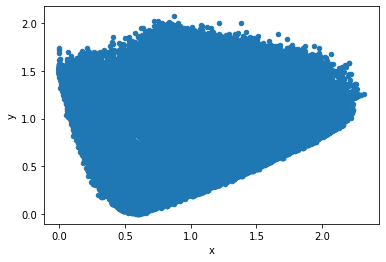

In [31]:
# plot the x,y coordinates
encoded_data.plot.scatter('x','y')

#### Pickle the Model

In [32]:
import pickle

# Dump the trained classifier (autoencoder)  with Pickle
pickle_filename = 'autoencoder_model.pkl'
pickled_model = open(pickle_filename, 'wb')  # Open the file to save as pkl file
pickle.dump(autoencoder, pickled_model)
pickled_model.close() # Close the pickle instances

# Loading the saved model
model_pkl = open(pickle_filename, 'rb')
autoencoder_model = pickle.load(model_pkl)
print ("Loaded model :: ", autoencoder_model)  # print to verify

Loaded model ::  <keras.engine.training.Model object at 0x7f4eafd606d8>


In [33]:
# Get test data

df_input = df_scaled[:1]
encoded_data_test = pd.DataFrame(encoder.predict(df_input))
encoded_data_test.columns = ['x', 'y']
encoded_data_test.head()

,x,y
0,1.544497,0.828816


In [34]:
test_x = encoder.predict(df_input)[0][0]
test_y = encoder.predict(df_input)[0][1]

### Get Distance

In [43]:
# example of euclidian distance
from scipy.spatial import distance
a = (1, 2, 3)
b = (4, 5, 6)
dst = distance.euclidean(a, b)

In [35]:
encoded_data.head()

,x,y
0,1.544497,0.828815
1,1.729073,0.819911
2,1.464176,1.673386
3,1.079835,1.347872
4,0.431884,1.223146


In [36]:
encoded_data['track_id'] = df['track_id']
encoded_data.head()

,x,y,track_id
0,1.544497,0.828815,0BRjO6ga9RKCKjfDqeFgWV
1,1.729073,0.819911,0BjC1NfoEOOusryehmNudP
2,1.464176,1.673386,0CoSDzoNIKCRs124s9uTVy
3,1.079835,1.347872,0Gc6TVm52BwZD07Ki6tIvf
4,0.431884,1.223146,0IuslXpMROHdEPvSl1fTQK


In [37]:
# save the encoded data as a .csv file    

encoded_data.to_csv("encoded_data.csv", index=False)

### Test out the pickled model

In [39]:
# test out reading it in.
df1 = pd.read_csv("encoded_data.csv")
df1.head()

,x,y,track_id
0,1.544497,0.828815,0BRjO6ga9RKCKjfDqeFgWV
1,1.729073,0.819911,0BjC1NfoEOOusryehmNudP
2,1.464176,1.673385,0CoSDzoNIKCRs124s9uTVy
3,1.079835,1.347872,0Gc6TVm52BwZD07Ki6tIvf
4,0.431884,1.223146,0IuslXpMROHdEPvSl1fTQK


In [40]:
encoded_data_test[['x','y']].values

array([[1.5444973, 0.8288155]], dtype=float32)

In [41]:
def get_e_dist(in_df):
  return distance.euclidean(in_df[[0,1]], (test_x,test_y))

In [44]:
encoded_data['e_distance'] = encoded_data.apply(get_e_dist, axis=1)

In [45]:
encoded_data.head()

,x,y,track_id,e_distance
0,1.544497,0.828815,0BRjO6ga9RKCKjfDqeFgWV,5.960464e-08
1,1.729073,0.819911,0BjC1NfoEOOusryehmNudP,1.847908e-01
2,1.464176,1.673386,0CoSDzoNIKCRs124s9uTVy,8.483808e-01
3,1.079835,1.347872,0Gc6TVm52BwZD07Ki6tIvf,6.966566e-01
4,0.431884,1.223146,0IuslXpMROHdEPvSl1fTQK,1.180425e+00


#### Get the 5 smallest distances and show the visuals for the top 2

In [46]:
encoded_data['e_distance'].nsmallest(5)

0         5.960464e-08
137871    3.013010e-03
190202    3.036266e-03
69761     3.136666e-03
117514    3.136666e-03
Name: e_distance, dtype: float64

In [47]:
print(df['track_name'][0])
print(df['track_name'][137871])
print(df['track_name'][190202])

C'est beau de faire un Show
Push Push
Los Angeles Is Burning


In [ ]:
df.iloc[[0,48095,38564]]


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.0000,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
48095,Blues,Shovels & Rope,The Wire,6XYY2YLbbQ6oNaDTrk5DGU,41,0.00622,0.557,176890,0.554,0.0000,B,0.103,-6.506,Minor,0.0506,135.084,4/4,0.628
38564,Electronic,Moksi,Dream,2h4EfdqxQsoCEL7eKIdUGz,31,0.02050,0.829,170887,0.769,0.0663,B,0.152,-7.388,Major,0.0702,123.984,4/4,0.523


In [ ]:
df_T = df_scaled.T

In [ ]:
import plotly.express as px

fig = px.bar_polar(df_T, r = 0,hover_name=headers)
fig.show()

In [ ]:
fig = px.bar_polar(df_T, r = 48095, hover_name=headers)
fig.show()

## Build a Function for DS Unit 3 to use

In [54]:
df.iloc[[13918]]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
13918,Dance,Britney Spears,Oops!...I Did It Again,6naxalmIoLFWR0siv8dnQQ,77,0.3,0.751,211160,0.834,0.000018,C#,0.355,-5.444,Minor,0.0437,95.053,4/4,0.894


In [55]:
# test
song_at = [[77,0.3,0.751,211160,0.834,0.000018,0.355,-5.444,0.0437,95.053,0.894]]

In [56]:
### Read in the CSV ###
database = pd.read_csv('encoded_data.csv')

In [57]:
def predict(song_attributes, database):
  """
  Need to pass in a variable that is an array with the below song attributes 
  in order.
  [[popularity, acousticness, danceability, duration_ms, energy, instrumentalness,
  liveness, loudness, speechiness, tempo, valence]]
  """

  import pandas as pd
  import pickle

  df =  pd.DataFrame(song_attributes)

  ### Scale Input ###

  # import the pickled scaler model
  pickle_filename_1 = 'scaler_model.pkl'
  scaler_pkl = open(pickle_filename_1, 'rb')
  scaler = pickle.load(scaler_pkl) 

   # scale the input data
  input_scaled = scaler.transform(df)

  ### Encode Input ###

  # Loading the pickled autoencoder model
  pickle_filename = 'autoencoder_model.pkl'
    
  autoencoder_pkl = open(pickle_filename, 'rb')
  autoencoder = pickle.load(autoencoder_pkl)
  # encode the input data and set to variable
  input_x_y = (autoencoder.predict(input_scaled)[0][0], 
               autoencoder.predict(input_scaled)[0][1])

  ### Get distances ###
  def get_e_dist(my_df):
    from scipy.spatial import distance
    return distance.euclidean(my_df[[0,1]], input_x_y)

  database['e_distance'] = database.apply(get_e_dist, axis=1)

  five_smallest = database[['e_distance','track_id']].nsmallest(5, columns='e_distance', keep='all')

  five_closest = five_smallest['track_id']

  return five_closest.to_json()

In [58]:
test = predict(song_at, database)
test

'{"138797":"3SnBd9X2oZHfnimgC0gwdt","188325":"3SnBd9X2oZHfnimgC0gwdt","206042":"0q4WJ5eId3glendOvoGk5u","64134":"33zGvjukiRoJgW6JWY0FMo","49633":"33zGvjukiRoJgW6JWY0FMo"}'

In [59]:
df.iloc[[13918,138797,188325,206042,64134,49633]]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
13918,Dance,Britney Spears,Oops!...I Did It Again,6naxalmIoLFWR0siv8dnQQ,77,0.300,0.751,211160,0.834,0.000018,C#,0.3550,-5.444,Minor,0.0437,95.053,4/4,0.8940
138797,Reggae,"Lee ""Scratch"" Perry",Jah I,3SnBd9X2oZHfnimgC0gwdt,26,0.291,0.803,214187,0.596,0.793000,A,0.3650,-5.603,Major,0.1150,145.578,4/4,0.6720
188325,Ska,"Lee ""Scratch"" Perry",Jah I,3SnBd9X2oZHfnimgC0gwdt,26,0.291,0.803,214187,0.596,0.793000,A,0.3650,-5.603,Major,0.1150,145.578,4/4,0.6720
206042,Soundtrack,John Paesano,Web Launch,0q4WJ5eId3glendOvoGk5u,29,0.276,0.271,181820,0.526,0.954000,C,0.0966,-13.130,Minor,0.0430,79.981,4/4,0.0483
64134,Folk,The Byrds,Draft Morning,33zGvjukiRoJgW6JWY0FMo,46,0.389,0.449,162160,0.487,0.868000,D,0.5450,-13.794,Major,0.0289,92.343,4/4,0.4950
49633,Blues,The Byrds,Draft Morning,33zGvjukiRoJgW6JWY0FMo,40,0.389,0.449,162160,0.487,0.868000,D,0.5450,-13.794,Major,0.0289,92.343,4/4,0.4950
